In [1]:
import h5py
import numpy as np
import pandas as pd
import pyts


In [2]:
## nueva forma de leer la data en un dataset
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:
        print("Keys: %s" % list(f.keys()))
        
        dataframes = []
        for key in list(f.keys()):
            print(f"Loading {key}: {type(f[key])}")
            dataset = np.array(f[key])
            
           
            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])
            
            dataframes.append(df)
        
        
        combined_df = pd.concat(dataframes, axis=1)
        return combined_df



In [3]:
##leemos la data
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_z: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading y: <class 'h5py._hl.dataset.Dataset'>
Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loadi

In [4]:
train_data.describe

<bound method NDFrame.describe of       body_acc_x_0  body_acc_x_1  body_acc_x_2  body_acc_x_3  body_acc_x_4  \
0         0.000181      0.010139      0.009276      0.005066      0.010810   
1         0.001094      0.004550      0.002879      0.002247      0.003305   
2         0.003531      0.002285     -0.000420     -0.003738     -0.006706   
3        -0.001772     -0.001311      0.000388      0.000408     -0.000355   
4         0.000087     -0.000272      0.001022      0.003126      0.002284   
...            ...           ...           ...           ...           ...   
7347      0.388873      0.618763      0.774067      0.586568      0.217007   
7348      0.711864      0.709237      0.321368     -0.028921     -0.208107   
7349     -0.226717     -0.177817     -0.150869     -0.132237     -0.068338   
7350     -0.064806     -0.079933     -0.068350     -0.038477     -0.028679   
7351     -0.194471     -0.173802     -0.127545     -0.108369     -0.121152   

      body_acc_x_5  body_acc_

In [5]:
test_data

,body_acc_x_0,body_acc_x_1,body_acc_x_2,body_acc_x_3,body_acc_x_4,body_acc_x_5,body_acc_x_6,body_acc_x_7,body_acc_x_8,body_acc_x_9,...,total_acc_z_118,total_acc_z_119,total_acc_z_120,total_acc_z_121,total_acc_z_122,total_acc_z_123,total_acc_z_124,total_acc_z_125,total_acc_z_126,total_acc_z_127
0,0.011653,0.013109,0.011269,0.027831,0.002318,-0.018965,-0.061920,-0.094248,-0.079534,-0.070084,...,0.155110,0.153346,0.149289,0.147401,0.146905,0.145261,0.143904,0.144395,0.144703,0.145494
1,0.009280,0.004930,0.003954,0.009214,0.016156,0.014079,0.013105,0.021247,0.026823,0.031054,...,0.133731,0.132851,0.132054,0.132224,0.139767,0.147877,0.153025,0.152788,0.139843,0.121314
2,0.005732,0.007066,0.005110,0.002434,0.002024,0.001382,0.001930,0.004875,0.003776,0.002400,...,0.131392,0.132404,0.134938,0.137589,0.134431,0.133174,0.133712,0.132678,0.132694,0.132117
3,0.000452,0.000604,-0.002485,-0.004562,-0.006002,-0.006382,-0.005276,-0.001489,0.005153,0.004951,...,0.126040,0.124815,0.125353,0.126463,0.121757,0.117611,0.118865,0.116060,0.110997,0.111912
4,-0.004362,-0.002765,-0.004905,-0.004682,-0.000267,0.004135,0.005626,0.000933,-0.001542,0.003020,...,0.129091,0.125772,0.126042,0.121086,0.118511,0.125458,0.129365,0.125895,0.122510,0.122760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.107662,0.124079,0.183420,0.289247,0.393799,0.446456,0.436931,0.363053,0.279962,0.152701,...,-0.386247,-0.358017,-0.328768,-0.343722,-0.408588,-0.402184,-0.351453,-0.330635,-0.254794,-0.229436
2943,-0.042392,-0.017244,0.015269,0.064482,0.086802,0.084482,0.101578,0.130484,0.208370,0.310620,...,-0.303917,-0.239700,-0.231936,-0.227728,-0.193037,-0.151306,-0.191359,-0.355499,-0.500135,-0.489756
2944,-0.147647,-0.169903,-0.168698,-0.138600,-0.144781,-0.072979,-0.040348,-0.023016,-0.025176,-0.074406,...,0.001781,-0.021745,-0.079452,-0.175389,-0.267170,-0.291177,-0.294972,-0.272397,-0.067734,0.137826
2945,0.071227,-0.088665,-0.070675,-0.116887,-0.214117,-0.219928,-0.275024,-0.229062,-0.245309,-0.242260,...,-0.156169,-0.128266,-0.083245,-0.015681,-0.017426,-0.038509,0.000626,-0.003512,-0.111786,-0.276068


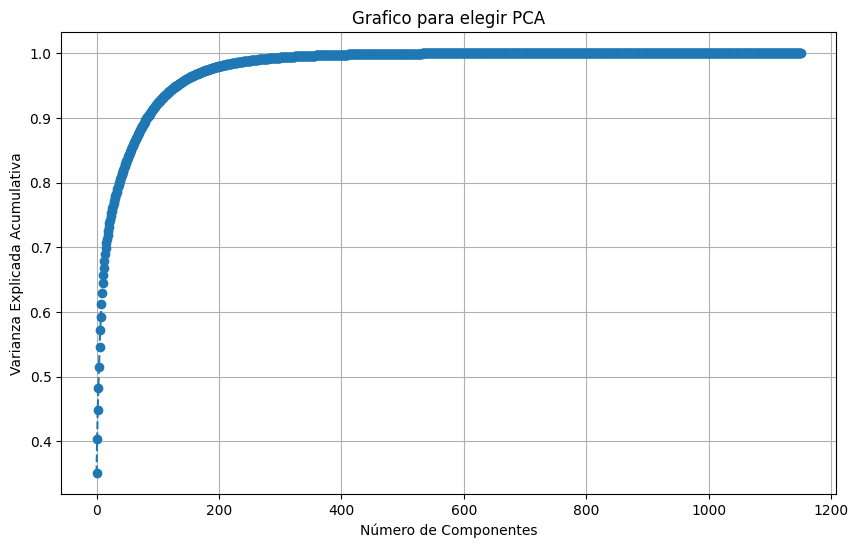

In [6]:
##elegimos el mejor numero de componenetes apra aplicar el PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


X = train_data.drop(columns=['y'])
Y = train_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)

pca = PCA().fit(X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Grafico para elegir PCA')
plt.grid(True)
plt.show()

In [7]:
## aplicamos PCA con 132 componentes

#X_test = test_data
n_components = np.argmax(explained_variance >= 0.95) + 1


pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f'Número de componentes seleccionados: {n_components}')

Número de componentes seleccionados: 132


In [8]:
print(len(X_train_pca[0]))

132


In [9]:
##aplicamos ROCKET por su rapidez y eficiencia

from pyts.transformation import ROCKET
rocket = ROCKET()
X_train_rocket = rocket.fit_transform(X_train_pca)
X_test_rocket = rocket.transform(X_test_pca)

In [10]:
print(len(X_train_rocket[0]))


20000


In [15]:
##intento de hacer el modelo de regresion logistica pero no hay y_test ni y_pred

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM': SVC()
}

In [16]:
for name, model in models.items():
    model.fit(X_train_rocket, y_train)
    y_pred = model.predict(X_test_rocket)
    
    ## aca no tengo el ytest que tendria q ser un vector
    print(f"Resultados para {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")

Resultados para Logistic Regression:
Accuracy: 0.9610154125113327
Classification Report:
               precision    recall  f1-score   support

         1.0       0.95      0.94      0.94       369
         2.0       0.94      0.96      0.95       337
         3.0       0.93      0.92      0.93       285
         4.0       0.96      0.97      0.96       385
         5.0       0.97      0.97      0.97       402
         6.0       1.00      1.00      1.00       428

    accuracy                           0.96      2206
   macro avg       0.96      0.96      0.96      2206
weighted avg       0.96      0.96      0.96      2206

Confusion Matrix:
 [[347   9  11   1   1   0]
 [  8 322   7   0   0   0]
 [ 11  11 263   0   0   0]
 [  1   0   2 372  10   0]
 [  0   1   0  13 388   0]
 [  0   0   0   0   0 428]]


Resultados para SVM:
Accuracy: 0.8862194016319129
Classification Report:
               precision    recall  f1-score   support

         1.0       0.80      0.88      0.84       369
